# WELL NOTEBOOK
## Well logs visualization &amp; petrophysics

Install the the repository reservoirpy from github and import the required packages

In [1]:
import os
path = os.path.abspath(os.path.join('..','..','..'))
import sys
sys.path.append(path)
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium
from pyproj import Proj, transform, CRS, Transformer
from reservoirpy.welllogspy import tracks as tk
from reservoirpy.welllogspy import petrophysics as pt
from reservoirpy.welllogspy.log import log 
from reservoirpy.wellpy import path as ph
from reservoirpy.wellproductivitypy import pi

### Well atributes

Well atributes, name, rte, coordinates, survey

In [2]:
#Create the well object
name = 'well-1'
rte = 515.78 # Rotary table Elevation
surf_coord = Point(1025165.89,1147730.75)
crs = 'EPSG:3117'
deviation = pd.read_csv('survey.csv', header=[0])
print(deviation.head())
print(deviation.tail())

      md   inc    azi
0    0.0  0.00    0.0
1  193.0  0.06    0.0
2  375.0  0.12    0.0
3  559.0  0.33  347.6
4  651.0  0.36  340.5
          md    inc     azi
132  12222.0  18.48  183.46
133  12312.0  18.32  183.53
134  12401.0  18.66  183.58
135  12488.0  19.28  182.83
136  12520.0  19.00  182.50


### Well Tops 

Data table of the tentative formation well tops from masterlog

In [3]:
#Tentative Formations Tops
tops = ph.tops([['fm1',0,7580],
         ['fm2',7581,8868],
         ['fm1',8869,9474],
         ['fm2',9475,9690],
         ['fm3',9691,9924],
         ['fm4',9925,9994],
         ['fm5',9995,10557],
         ['fm6',10558,10798],
         ['fm7',10799,11108],
         ['fm8',11109,11288],
         ['fm9',11289,11317,20,170,1.5],
         ['fm10',11318,11965,10,170,2],
         ['fm11',11966,12080,50,190,0.12],
         ['fm12',12081,12222,50,190,0.12],
         ['fm13',12223,12233,50,190,0.1],
         ['fm14',12234,12520,15,170,0.1]], 
         columns=['formation','md_top','md_bottom','gr_sand','gr_shale','rw'])
tops

,formation,md_top,md_bottom,gr_sand,gr_shale,rw
0,fm1,0,7580,NaN,NaN,NaN
1,fm2,7581,8868,NaN,NaN,NaN
2,fm1,8869,9474,NaN,NaN,NaN
3,fm2,9475,9690,NaN,NaN,NaN
4,fm3,9691,9924,NaN,NaN,NaN
5,fm4,9925,9994,NaN,NaN,NaN
6,fm5,9995,10557,NaN,NaN,NaN
7,fm6,10558,10798,NaN,NaN,NaN
8,fm7,10799,11108,NaN,NaN,NaN
9,fm8,11109,11288,NaN,NaN,NaN


### Import the logs
Import the masterlog and openhole log

In [4]:
# list of mnemonics 
#mn = pd.read_csv('mnemonics.csv')

#Upload logs
masterlog = log('master.las')
openlog = log('logs.las', find_mnemonics=True)

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


Mnemonic:  ROPA  =>  ROP_ROPA
Mnemonic:  AFRMC  =>  RM_AFRMC
Mnemonic:  AFRSC  =>  RS_AFRSC
Mnemonic:  AFRDC  =>  RD_AFRDC
Mnemonic:  ALCDLC  =>  RHOB_ALCDLC
Mnemonic:  ALDCLC  =>  DCOR_ALDCLC
Mnemonic:  ALPELC  =>  PEF_ALPELC
Mnemonic:  TNPS  =>  NPHI_TNPS


## Create the well with its atributes

In [5]:
#Create the well
b2 = ph.well(name='well-1', 
             rte=rte, 
             surf_coord=surf_coord, 
             crs=crs, 
             deviation=deviation, 
             tops=tops, 
             masterlog=masterlog, 
             openlog=openlog)

### Methods

Once the well is created with its attributes multiple operations can be made:
- Estimate Survey
- Make sample deviation and sample position
- Convert md to Tvd, Tvdss, Coord
- Assign formations depth to logs depending on the well tops



### Survey

By using the minimumm curvature ratio it estimates the Tvd, Northing, Easting and dogleg. 
the method also create the Point Shape object for each point

In [6]:
b2.survey.head()

,inc,azi,tvd,tvdss,north_offset,east_offset,northing,easting,dleg,geometry
md,,,,,,,,,,
0.0,0.00,0.0,0.000000,515.780000,0.000000,0.000000,1.147731e+06,1.025166e+06,0.000000,POINT (1025165.890 1147730.750)
193.0,0.06,0.0,192.999965,322.780035,0.101055,0.000000,1.147731e+06,1.025166e+06,0.031088,POINT (1025165.890 1147730.781)
375.0,0.12,0.0,374.999732,140.780268,0.386939,0.000000,1.147731e+06,1.025166e+06,0.032967,POINT (1025165.890 1147730.868)
559.0,0.33,347.6,558.998219,-43.218219,1.097142,-0.113784,1.147731e+06,1.025166e+06,0.116497,POINT (1025165.855 1147731.084)
651.0,0.36,340.5,650.996554,-135.216554,1.628348,-0.267154,1.147731e+06,1.025166e+06,0.056709,POINT (1025165.809 1147731.246)


### Convert Coordinates system
You can easily convert to other coordinate system for map plotting

In [7]:
b2.survey.to_crs("EPSG:4326").head()

,inc,azi,tvd,tvdss,north_offset,east_offset,northing,easting,dleg,geometry
md,,,,,,,,,,
0.0,0.00,0.0,0.000000,515.780000,0.000000,0.000000,1.147731e+06,1.025166e+06,0.000000,POINT (-70.85023 5.93207)
193.0,0.06,0.0,192.999965,322.780035,0.101055,0.000000,1.147731e+06,1.025166e+06,0.031088,POINT (-70.85023 5.93207)
375.0,0.12,0.0,374.999732,140.780268,0.386939,0.000000,1.147731e+06,1.025166e+06,0.032967,POINT (-70.85023 5.93207)
559.0,0.33,347.6,558.998219,-43.218219,1.097142,-0.113784,1.147731e+06,1.025166e+06,0.116497,POINT (-70.85023 5.93208)
651.0,0.36,340.5,650.996554,-135.216554,1.628348,-0.267154,1.147731e+06,1.025166e+06,0.056709,POINT (-70.85023 5.93208)


### Transform the coordinates and mapping

In [8]:
#Transform the Surface Coordinate from EPSG:3117 to 4326
print(b2.surf_coord.wkt)
tr = Transformer.from_crs("EPSG:3117", "EPSG:4326",always_xy=True)
x2,y2 = tr.transform(b2.surf_coord.x, b2.surf_coord.y)
p_4326 = Point(x2,y2)

print(p_4326.wkt)

#surv_geojson = b2.survey.to_crs("EPSG:4326").to_json()

#Map
m = folium.Map(location=[p_4326.y,p_4326.x],zoom_start=15)
folium.Marker([p_4326.y, p_4326.x], popup='Boral-2').add_to(m)
#folium.GeoJson(surv_geojson,name='survey').add_to(m)
m

POINT (1025165.89 1147730.75)
POINT (-70.85023050412562 5.932072054847613)


### Resample Survey 

You can resample the deviation and position according to a given step size

In [9]:
#Sample Deviation
b2.sample_deviation(step=1000)

,new_md,new_inc,new_azi
0,0.0,0.000000,0.000000
1,1000.0,0.364333,101.666778
2,2000.0,1.580000,245.030000
3,3000.0,1.040562,72.794719
4,4000.0,0.874000,236.590667
5,5000.0,0.397000,213.964444
6,6000.0,0.223418,298.941772
7,7000.0,2.726667,185.421111
8,8000.0,13.762247,185.769888
9,9000.0,19.858889,183.477778


In [10]:
#Sample Position
b2.sample_position(step=1000)

,new_tvd,new_easting,new_northing,geometry
0,0.000000,1.025166e+06,1.147731e+06,POINT (1025165.890 1147730.750)
1,1000.000000,1.025166e+06,1.147732e+06,POINT (1025166.052 1147731.607)
2,2000.000000,1.025168e+06,1.147732e+06,POINT (1025167.896 1147731.890)
3,3000.000000,1.025164e+06,1.147734e+06,POINT (1025164.082 1147734.440)
4,4000.000000,1.025168e+06,1.147733e+06,POINT (1025167.686 1147732.916)
5,5000.000000,1.025166e+06,1.147731e+06,POINT (1025165.649 1147731.295)
6,6000.000000,1.025165e+06,1.147730e+06,POINT (1025165.444 1147730.355)
7,7000.000000,1.025163e+06,1.147727e+06,POINT (1025163.041 1147727.404)
8,8000.000000,1.025160e+06,1.147688e+06,POINT (1025159.885 1147687.940)
9,9000.000000,1.025155e+06,1.147588e+06,POINT (1025154.719 1147587.689)


In [11]:
surv_geojson = b2.sample_position(step=1500).to_crs("EPSG:4326").to_json()

#Map
m = folium.Map(location=[p_4326.y,p_4326.x],zoom_start=16)
folium.Marker([p_4326.y, p_4326.x], popup='Boral-2').add_to(m)
folium.GeoJson(surv_geojson,name='survey').add_to(m)
m

### Function to convert easily md to tvd, tvdss, and coord

In [12]:
depth = 10525

d_tvd, = b2.to_tvd(md=depth)
d_tvdss, = b2.to_tvd(md=depth,ss=True)
d_coord, = b2.to_coord(md=depth)

print(f"From {depth} md to: \n  {d_tvd} tvd \n  {d_tvdss} tvdss \n  {d_coord.wkt}")

From 10525 md to: 
  10375.274675782086 tvd 
  -9859.494675782085 tvdss 
  POINT (1025146.067017453 1147438.041069868)


## Get the tvd tvdss and coord of formation well tops

In [13]:
b2.to_tvd(which=['tops'])


[   formation  md_top  md_bottom  gr_sand  gr_shale    rw       tvd_top  \
 0        fm1       0       7580      NaN       NaN   NaN      0.000000   
 1        fm2    7581       8868      NaN       NaN   NaN   7577.959424   
 2        fm1    8869       9474      NaN       NaN   NaN   8815.986710   
 3        fm2    9475       9690      NaN       NaN   NaN   9385.439216   
 4        fm3    9691       9924      NaN       NaN   NaN   9588.270350   
 5        fm4    9925       9994      NaN       NaN   NaN   9808.956914   
 6        fm5    9995      10557      NaN       NaN   NaN   9875.050125   
 7        fm6   10558      10798      NaN       NaN   NaN  10406.500187   
 8        fm7   10799      11108      NaN       NaN   NaN  10634.464425   
 9        fm8   11109      11288      NaN       NaN   NaN  10927.238824   
 10       fm9   11289      11317     20.0     170.0  1.50  11097.725298   
 11      fm10   11318      11965     10.0     170.0  2.00  11125.126179   
 12      fm11   11966    

In [14]:
b2.to_tvd(which=['tops'], ss=True)

[   formation  md_top  md_bottom  gr_sand  gr_shale    rw       tvd_top  \
 0        fm1       0       7580      NaN       NaN   NaN      0.000000   
 1        fm2    7581       8868      NaN       NaN   NaN   7577.959424   
 2        fm1    8869       9474      NaN       NaN   NaN   8815.986710   
 3        fm2    9475       9690      NaN       NaN   NaN   9385.439216   
 4        fm3    9691       9924      NaN       NaN   NaN   9588.270350   
 5        fm4    9925       9994      NaN       NaN   NaN   9808.956914   
 6        fm5    9995      10557      NaN       NaN   NaN   9875.050125   
 7        fm6   10558      10798      NaN       NaN   NaN  10406.500187   
 8        fm7   10799      11108      NaN       NaN   NaN  10634.464425   
 9        fm8   11109      11288      NaN       NaN   NaN  10927.238824   
 10       fm9   11289      11317     20.0     170.0  1.50  11097.725298   
 11      fm10   11318      11965     10.0     170.0  2.00  11125.126179   
 12      fm11   11966    

In [15]:
b2.to_coord(which=['tops'])

[   formation  md_top  md_bottom  gr_sand  gr_shale    rw       tvd_top  \
 0        fm1       0       7580      NaN       NaN   NaN      0.000000   
 1        fm2    7581       8868      NaN       NaN   NaN   7577.959424   
 2        fm1    8869       9474      NaN       NaN   NaN   8815.986710   
 3        fm2    9475       9690      NaN       NaN   NaN   9385.439216   
 4        fm3    9691       9924      NaN       NaN   NaN   9588.270350   
 5        fm4    9925       9994      NaN       NaN   NaN   9808.956914   
 6        fm5    9995      10557      NaN       NaN   NaN   9875.050125   
 7        fm6   10558      10798      NaN       NaN   NaN  10406.500187   
 8        fm7   10799      11108      NaN       NaN   NaN  10634.464425   
 9        fm8   11109      11288      NaN       NaN   NaN  10927.238824   
 10       fm9   11289      11317     20.0     170.0  1.50  11097.725298   
 11      fm10   11318      11965     10.0     170.0  2.00  11125.126179   
 12      fm11   11966    

In [16]:
b2.tops.head()

,formation,md_top,md_bottom,gr_sand,gr_shale,rw,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,northing,easting,geometry
0,fm1,0,7580,NaN,NaN,NaN,0.000000,7576.968659,7576.968659,515.780000,-7061.188659,1.147731e+06,1.025162e+06,POINT (1025162.280 1147730.750)
1,fm2,7581,8868,NaN,NaN,NaN,7577.959424,8815.043031,1237.083607,-7062.179424,-8299.263031,1.147713e+06,1.025156e+06,POINT (1025156.083 1147712.789)
2,fm1,8869,9474,NaN,NaN,NaN,8815.986710,9384.503530,568.516820,-8300.206710,-8868.723530,1.147608e+06,1.025152e+06,POINT (1025152.479 1147607.620)
3,fm2,9475,9690,NaN,NaN,NaN,9385.439216,9587.327616,201.888401,-8869.659216,-9071.547616,1.147545e+06,1.025151e+06,POINT (1025150.759 1147544.575)
4,fm3,9691,9924,NaN,NaN,NaN,9588.270350,9808.012772,219.742422,-9072.490350,-9292.232772,1.147522e+06,1.025150e+06,POINT (1025149.512 1147522.012)


### Assign to each depth of the logs a Formation according to tops

In [17]:
b2.tops_to_logs(which=['masterlog','openlog'])

In [18]:
b2.masterlog.df().tail()

,ROPA,HYDC1,METH1,ETH1,PRP1,IBUT1,NBUT1,IPEN1,NPEN1,CO2_1,H2S2,LFL2,formation
DMEA,,,,,,,,,,,,,
12516.0,35.6436,894.289,736.657,96.639,41.876,1.519,7.647,2.540,7.411,210.199,0.0,0.0,fm14
12517.0,34.2692,2545.211,2164.197,217.526,123.447,9.695,14.882,4.183,11.281,162.025,0.0,0.0,fm14
12518.0,34.9515,2628.309,2245.937,221.717,119.360,9.799,14.014,5.928,11.554,167.396,0.0,0.0,fm14
12519.0,35.3010,1721.319,1475.228,151.067,71.323,0.047,10.221,4.085,9.348,189.642,0.0,0.0,fm14
12520.0,37.5158,1082.963,927.505,94.156,41.374,3.010,6.438,3.655,6.825,192.057,0.0,0.0,fm14


In [19]:
b2.openlog.df().head()

,ROP_ROPA,DGRCC,R09PC,R15PC,R27PC,R39PC,ARH16PC,ARH32PC,ARH48PC,ARM48PC,...,RS_AFRSC,RD_AFRDC,ABR,RHOB_ALCDLC,DCOR_ALDCLC,PEF_ALPELC,NPHI_TNPS,ALHSI,STEMP,formation
DEPT,,,,,,,,,,,,,,,,,,,,,
450.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fm1
450.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fm1
450.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fm1
450.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fm1
451.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fm1


### Logs Visualization
Plot the initial curves since the C8 formation to Ubaque

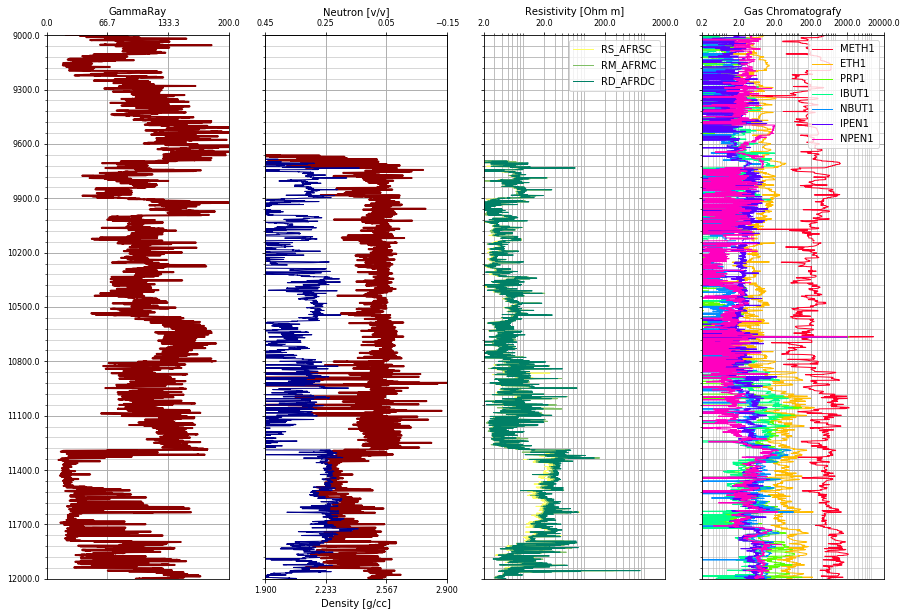

In [20]:

logs = b2.openlog.df()
master = b2.masterlog.df()

From = 9000
To = 12000

fig, ax = plt.subplots(1,4, figsize=(15,10))

tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], lims=[From,To])
tk.dntrack(logs,rho='RHOB_ALCDLC',ntr='NPHI_TNPS', ax=ax[1],lims=[From,To])
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[2], res_range=[2,2000],lims=[From,To])
tk.gastrack(master, gas=['METH1', 'ETH1', 'PRP1', 'IBUT1', 'NBUT1', 'IPEN1','NPEN1'], ax=ax[3],lims=[From,To])

### Add formations tops 

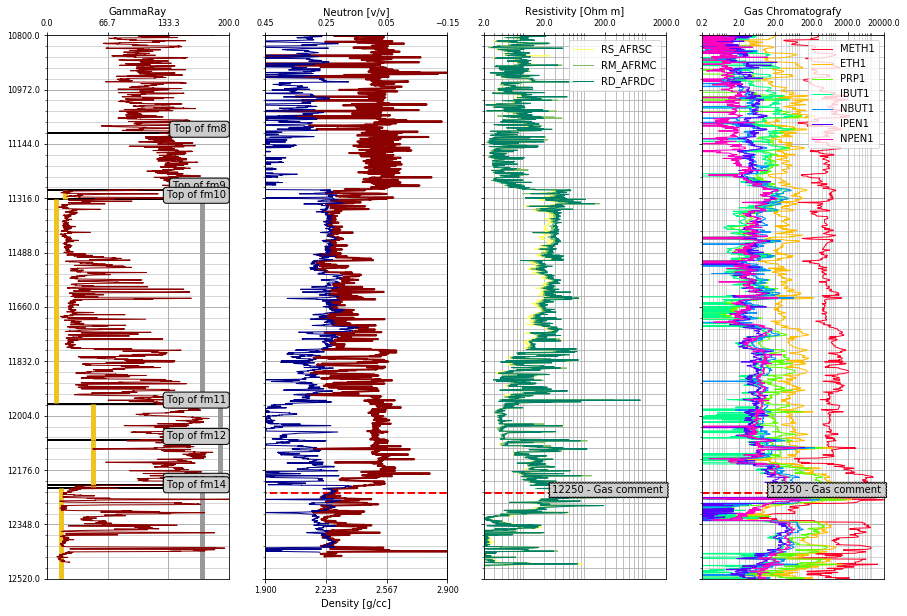

In [21]:
anot = pd.DataFrame({'depth':[12250],'comment':["Gas comment"]})

tops = b2.tops

From = 10800
To = 12520

fig, ax = plt.subplots(1,4, figsize=(15,10))

tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], gr_sand_shale = tops, fm = tops,
           fm_kw={'ann':True,'color':'black', 'linewidth':2}, 
           gr_kw={'linewidth':1}, 
           gr_sand_kw={'linewidth':5, 'color':(237/255,196/255,33/255)},
           gr_shale_kw={'linewidth':5, 'color':(0.6,0.6,0.6)},lims=[From,To] )


tk.dntrack(logs,rho='RHOB_ALCDLC',ntr='NPHI_TNPS', ax=ax[1],correlation=anot,lims=[From,To])
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[2], res_range=[2,2000],correlation=anot,corr_kw={'ann':True},lims=[From,To])
tk.gastrack(master, gas=['METH1', 'ETH1', 'PRP1', 'IBUT1', 'NBUT1', 'IPEN1','NPEN1'], ax=ax[3], correlation=anot,corr_kw={'ann':True},lims=[From,To])

## Petrophysical calculation

In [22]:
logpt = pd.DataFrame()
for i in b2.tops.iterrows():

    logv = pt.petrophysics(logs,i[1]['md_top'],i[1]['md_bottom'],
                           vshale_gr_kw=dict(vsh_col_name='vsh_gr', gr_name='DGRCC', gr_sand=i[1]['gr_sand'], gr_shale = i[1]['gr_shale']),
                           vshale_dn_kw=dict(vsh_col_name='vsh_dn', rho_name='RHOB_ALCDLC',ntr_name='NPHI_TNPS'),
                           phi_rho_kw=dict(phi_rho_name='phi_rho', rho_name='RHOB_ALCDLC'),
                           phie_kw=dict(phi_rho_name='phi_rho',ntr_name='NPHI_TNPS', vsh_name='vsh_dn'),
                           sw_kw=dict(rt_name='RD_AFRDC',phi_name='phie_avg',vsh_name='vsh_dn', rw=i[1]['rw'], methods=['archie','indo'],a=1,m=2,n=2),
                           flag_kw=dict(vsh_name='vsh_gr',phi_name='phie_avg',sw_name='archie',vsh_cutoff=0.7, phi_cutoff=0.1,sw_cutoff=0.60,which='pay'),
                           perm_kw = dict(phi_name='phie_avg',swir=0.1,authors=['timur','morris','coates']),
                           kh_kw = dict(perm_name='timur', pay_name='pay_flag'),
                          return_partial=True)
    
    logpt = logpt.append(logv)
logpt.columns

/home/santiago/Documents/dev/reservoirpy/reservoirpy/welllogspy/petrophysics/petroequations.py:10: RuntimeWarning: invalid value encountered in less
  igr[igr < 0.0] = 0.0
/home/santiago/Documents/dev/reservoirpy/reservoirpy/welllogspy/petrophysics/petroequations.py:11: RuntimeWarning: invalid value encountered in greater
  igr[igr > 1.0] = 1.0
/home/santiago/Documents/dev/reservoirpy/reservoirpy/welllogspy/petrophysics/petroequations.py:36: RuntimeWarning: invalid value encountered in less
  vsh[vsh < 0.0] = 0.0
/home/santiago/Documents/dev/reservoirpy/reservoirpy/welllogspy/petrophysics/petroequations.py:37: RuntimeWarning: invalid value encountered in greater
  vsh[vsh > 1.0] = 1.0
/home/santiago/Documents/dev/reservoirpy/reservoirpy/welllogspy/petrophysics/petroequations.py:46: RuntimeWarning: invalid value encountered in less
  phi_rho_curve[phi_rho_curve < 0.0] = 0.0
/home/santiago/Documents/dev/reservoirpy/reservoirpy/welllogspy/petrophysics/petroequations.py:47: RuntimeWarning:

Index(['ROP_ROPA', 'DGRCC', 'R09PC', 'R15PC', 'R27PC', 'R39PC', 'ARH16PC',
       'ARH32PC', 'ARH48PC', 'ARM48PC', 'RM_AFRMC', 'RS_AFRSC', 'RD_AFRDC',
       'ABR', 'RHOB_ALCDLC', 'DCOR_ALDCLC', 'PEF_ALPELC', 'NPHI_TNPS', 'ALHSI',
       'STEMP', 'formation', 'vsh_gr', 'vsh_dn', 'phi_rho', 'phia', 'phie_avg',
       'phie_rho', 'phie_ntr', 'archie', 'indo', 'timur', 'morris', 'coates',
       'sand_flag', 'reservoir_flag', 'pay_flag', 'kh', 'kh_norm'],
      dtype='object')

/home/santiago/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


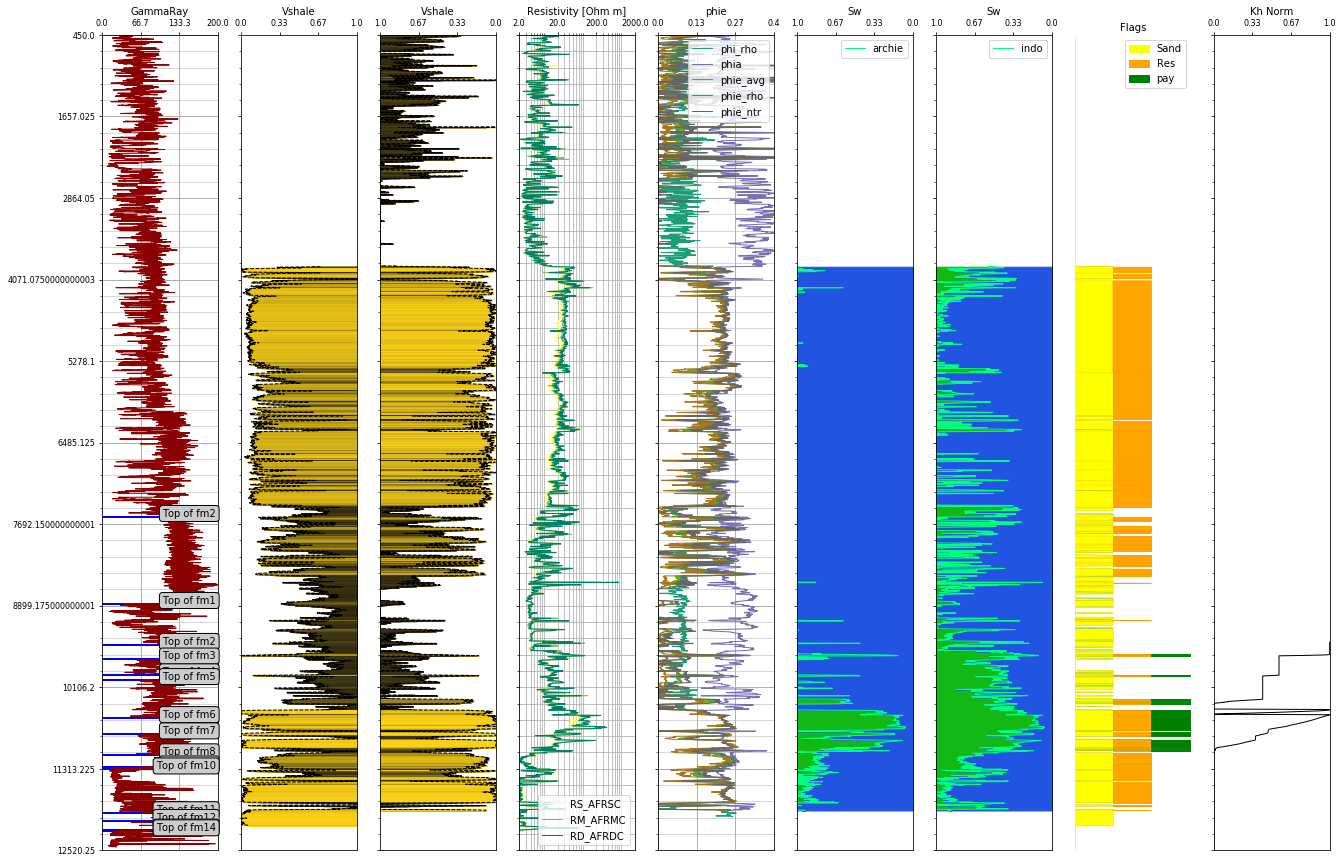

In [23]:
From = 10800
To = 12520

fig, ax = plt.subplots(1,9, figsize=(22,15))
tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], fm=tops, 
           fm_kw={'ann':True,'color':'blue', 'linewidth':2}, 
           gr_kw={'linewidth':1})

tk.vshtrack(logpt,vsh='vsh_gr',ax=ax[1],fill=True, inverse=False,lims=[From,To])
tk.vshtrack(logpt,vsh='vsh_dn',ax=ax[2],fill=True, inverse=True,lims=[From,To])
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[3], res_range=[2,2000],lims=[From,To])
tk.swtrack(logpt, sw=['archie'],ax=ax[5], fill=True,lims=[From,To])
tk.swtrack(logpt, sw=['indo'],ax=ax[6], fill=True,lims=[From,To])
tk.phietrack(logpt,phi=['phi_rho', 'phia', 'phie_avg','phie_rho', 'phie_ntr'], ax=ax[4],lims=[From,To])
tk.flagtrack(logpt, sand='sand_flag',res='reservoir_flag',pay='pay_flag', ax=ax[7], legend=True,lims=[From,To])
tk.khtrack(logpt, kh='kh_norm', ax=ax[8], fill=False,lims=[From,To])
#tk.ktrack(logpt,k=['timur'],ax=ax[9],k_range=[0.1,10000])

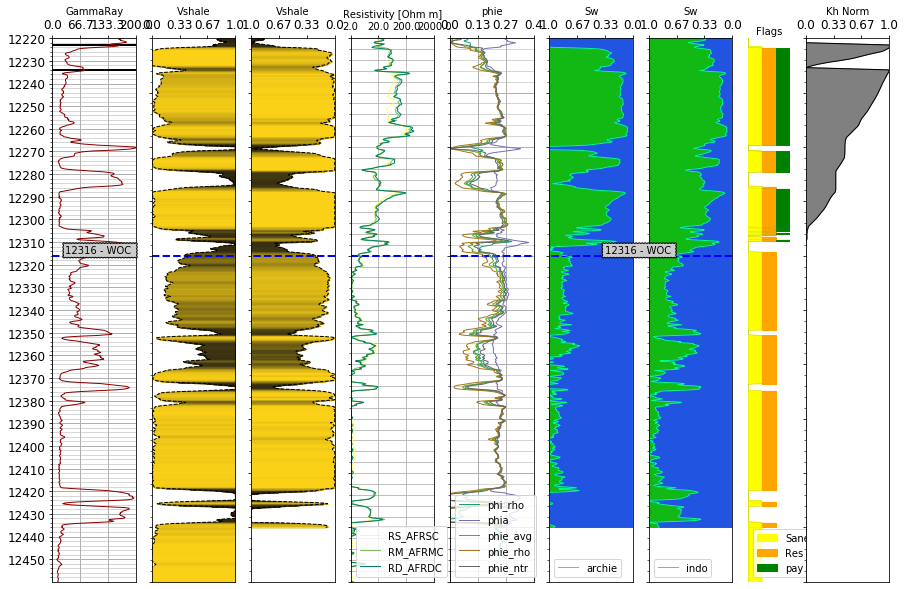

In [24]:
woc = pd.DataFrame({'depth':[12316],'comment':["WOC"]})

From = 12220
To = 12460

fig, ax = plt.subplots(1,9, figsize=(15,10),gridspec_kw={'width_ratios':[1,1,1,1,1,1,1,0.5,1]})
tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], fm=tops, 
           fm_kw={'ann':False,'color':'black', 'linewidth':2}, 
           gr_kw={'linewidth':1}, lims=[From,To],steps=[10,2],fontsize=12,correlation=woc,corr_kw={'ann':True, 'color':'blue'})

tk.vshtrack(logpt,vsh='vsh_gr',ax=ax[1],fill=True, inverse=False, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.vshtrack(logpt,vsh='vsh_dn',ax=ax[2],fill=True, inverse=True, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[3], res_range=[2,2000], lims=[From,To],fontsize=10,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.swtrack(logpt, sw=['archie'],ax=ax[5], fill=True, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.swtrack(logpt, sw=['indo'],ax=ax[6], fill=True, lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':True, 'color':'blue'})
tk.phietrack(logpt,phi=['phi_rho', 'phia', 'phie_avg','phie_rho', 'phie_ntr'], ax=ax[4], lims=[From,To],fontsize=12,correlation=woc,corr_kw={'ann':False, 'color':'blue'})
tk.flagtrack(logpt, sand='sand_flag',res='reservoir_flag',pay='pay_flag', ax=ax[7], legend=True, lims=[From,To],fontsize=12)
tk.khtrack(logpt, kh='kh_norm', ax=ax[8], lims=[From,To],fontsize=12)
#tk.ktrack(logpt,k=['coates','morris','timur'],ax=ax[9],lims=[From,To], colormap='Blues')

## Add  the petrophysics curves to b2.openlogs

In [25]:
b2.add_to_logs(logpt)


# Take Only one formation

We can compare petrophysical properties between intervals choosen

Two intervals from Fm13 and fm14 were choosen at top of the zones. The main properties like mid points, tickness are estimated. Besides a summary of the petrophysical paremeters can be attached to them

In [26]:
# Create the perforations class
p_tentative= ph.perforations({'md_top':[12224,12234],'md_bottom':[12232,12242]})

#Add to the Attribute perforations in the Well object
b2.perforations = p_tentative 

#Estimate tvd and tvdss
b2.to_tvd(which=['perforations'])
b2.to_tvd(which=['perforations'],ss=True)

# Estimate the intervals tick
b2.perforations.get_tick()
b2.perforations.get_mid_point()

,md_top,md_bottom,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,md_tick,md_mid_point,tvd_mid_point,tvdss_mid_point
0,12224,12232,11981.381637,11988.972643,7.591006,-11465.601637,-11473.192643,8,12228.0,11985.177140,-11469.397140
1,12234,12242,11990.870394,11998.461400,7.591006,-11475.090394,-11482.681400,8,12238.0,11994.665897,-11478.885897


Once the intervals have been added to the Wells object. You can get a summary of the petrophysical parameters or any curve on the logs. Choose the curves and optionally add an dictionary with the aggregate functions to show

In [27]:
# Get a summary for the intervals of interest
pp = b2.interval_attributes(perforations=True,
                       curves=['vsh_dn','phie_avg','archie','timur','coates','kh'],
                       aggfunc={'vsh_dn':'mean','phie_avg':['min','max','mean'],
                               'archie':['min','max','mean'],'coates':['min','max','mean'],
                               'kh':'sum'})
pp

,md_top,md_bottom,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,md_tick,md_mid_point,tvd_mid_point,...,"(phie_avg, min)","(phie_avg, max)","(phie_avg, mean)","(archie, min)","(archie, max)","(archie, mean)","(coates, min)","(coates, max)","(coates, mean)","(kh, sum)"
0.0,12224,12232,11981.381637,11988.972643,7.591006,-11465.601637,-11473.192643,8,12228.0,11985.177140,...,0.089359,0.174152,0.150632,0.222784,1.000000,0.321323,5.738459,82.785534,49.892554,732.054260
1.0,12234,12242,11990.870394,11998.461400,7.591006,-11475.090394,-11482.681400,8,12238.0,11994.665897,...,0.169648,0.236727,0.218984,0.083474,0.456206,0.160189,74.547543,282.637857,212.089875,3620.486361


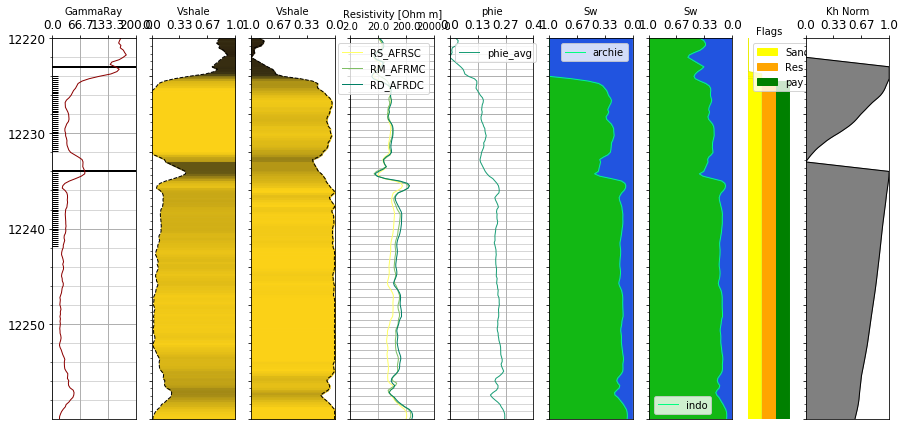

In [28]:
From = 12220
To = 12260

fig, ax = plt.subplots(1,9, figsize=(15,7),gridspec_kw={'width_ratios':[1,1,1,1,1,1,1,0.5,1]})
tk.grtrack(logs,gr='DGRCC', gr_max=200, ax=ax[0], fm=tops[(tops['md_top']>From)&(tops['md_top']<To)], 
           fm_kw={'ann':False,'color':'black', 'linewidth':2}, 
           gr_kw={'linewidth':1}, lims=[From,To],steps=[10,2],fontsize=12, perf=pp)

tk.vshtrack(logpt,vsh='vsh_gr',ax=ax[1],fill=True, inverse=False, lims=[From,To],fontsize=12)
tk.vshtrack(logpt,vsh='vsh_dn',ax=ax[2],fill=True, inverse=True, lims=[From,To],fontsize=12)
tk.restrack(logs, res=['RS_AFRSC', 'RM_AFRMC', 'RD_AFRDC'], ax=ax[3], res_range=[2,2000], lims=[From,To],fontsize=10,)
tk.swtrack(logpt, sw=['archie'],ax=ax[5], fill=True, lims=[From,To],fontsize=12)
tk.swtrack(logpt, sw=['indo'],ax=ax[6], fill=True, lims=[From,To],fontsize=12)
tk.phietrack(logpt,phi=['phie_avg'], ax=ax[4], lims=[From,To],fontsize=12)
tk.flagtrack(logpt, sand='sand_flag',res='reservoir_flag',pay='pay_flag', ax=ax[7], legend=True, lims=[From,To],fontsize=12)
tk.khtrack(logpt, kh='kh_norm', ax=ax[8], lims=[From,To],fontsize=12)

## Initial pressure and Productivity Index is estimated

Taking the reservoir pressure at datum to the mid perforations points. 

The Productivity Index is calculated with the fluids properties as well as the Inflow curve

In [29]:
pr = 4970
datum = -11371

b2.perforations['mu'] = 4.8
b2.perforations['bo'] = 1.240
b2.perforations['go'] = 0.8403*0.433
b2.perforations['gw'] = 0.433
b2.perforations['pb'] = 3241
b2.perforations['pr'] = b2.perforations.apply(lambda x: pr + ((datum-x['tvdss_mid_point'])*((x['gw']*x[('archie', 'max')])+(x['go']*(1-x[('archie', 'max')])))),axis=1)


b2.perforations['j'] = b2.perforations.apply(lambda x: pi.oil_j(x['mu'],x['bo'],kh=x[('kh', 'sum')]), axis=1)
b2.perforations['inflow'] = b2.perforations.apply(lambda x: pi.oil_inflow(pr=x['pr'],j=x['j'],pb=x['pb']),axis=1)
b2.perforations

,md_top,md_bottom,tvd_top,tvd_bottom,tvd_tick,tvdss_top,tvdss_bottom,md_tick,md_mid_point,tvd_mid_point,...,"(coates, mean)","(kh, sum)",mu,bo,go,gw,pb,pr,j,inflow
0.0,12224,12232,11981.381637,11988.972643,7.591006,-11465.601637,-11473.192643,8,12228.0,11985.177140,...,49.892554,732.054260,4.8,1.24,0.36385,0.433,3241,5012.605962,0.122625,Oil Inflow: \n Reservoir Pressure: ...
1.0,12234,12242,11990.870394,11998.461400,7.591006,-11475.090394,-11482.681400,8,12238.0,11994.665897,...,212.089875,3620.486361,4.8,1.24,0.36385,0.433,3241,5012.657714,0.606460,Oil Inflow: \n Reservoir Pressure: ...


## Plot inflow curves

The difference in the petrophysical perameters calculated show a difference in productivity

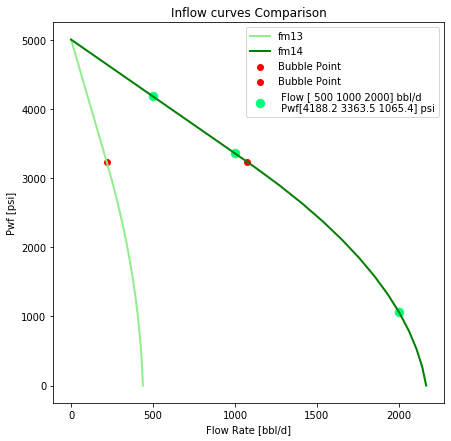

In [30]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

b2.perforations['inflow'][0.0].plot(ax=ax, label='fm13',color='lightgreen')
b2.perforations['inflow'][1.0].plot(ax=ax, label='fm14', color='green',flow=[500,1000,2000])
ax.set_title('Inflow curves Comparison')
ax.legend()

## Relative Permeabilities and fractional flow

Taken from Dynamic model Presentation

The fractional flow curve is estimated based on the relative permeabilities used in the reservoir simulation model to predict the initial water cut

In [31]:
rel_perm = pd.DataFrame({'sw':[0.1,0.15,0.21,0.26,0.31,0.37,0.42,0.48,0.53,0.58,0.64,0.69,0.74,0.8,0.85,1.0],
                        'krw':[0,0,0,0,0,0,0.01,0.01,0.02,0.04,0.07,0.12,0.19,0.28,0.40,0.40],
                        'kro':[1,0.89,0.78,0.68,0.58,0.49,0.41,0.33,0.26,0.19,0.13,0.09,0.04,0.01,0,0]})
rel_perm = rel_perm.set_index('sw')

### Fractional Flow Initial Water Cut

/home/santiago/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


Text(0, 0.5, 'Fw')

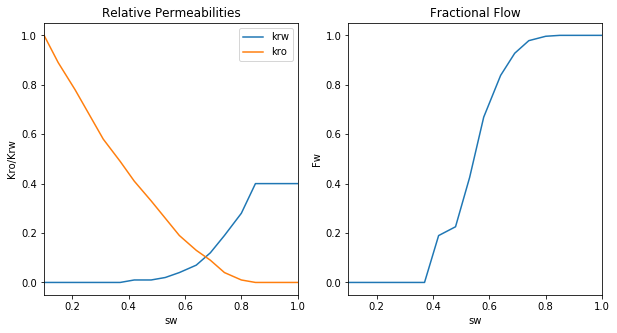

In [32]:
muo=4.8
muw=0.5

rel_perm['ff'] = rel_perm.apply(lambda x: 1/(1+((x['kro']*muw)/((x['krw']*muo)))),axis=1)

fig,ax = plt.subplots(1,2, figsize=(10,5))

rel_perm[['krw','kro']].plot(ax=ax[0])
ax[0].set_title('Relative Permeabilities')
ax[0].set_ylabel('Kro/Krw')
rel_perm['ff'].plot(ax=ax[1])
ax[1].set_title('Fractional Flow')
ax[1].set_ylabel('Fw')

In [33]:
b2.perforations[['md_top','md_bottom',('archie','mean')]]

,md_top,md_bottom,"(archie, mean)"
0.0,12224,12232,0.321323
1.0,12234,12242,0.160189


According with the relative permebilities and the average water saturation in the intervals the initial water cut would be very low